Compute scores for literally hard and easy examples:

- phrase lexical overlap is larger than \theta
- otherwise

In [2]:
% cd /home/mayu-ot/durga/Experiments/loc_iparaphrasing/

from chainercv.utils import bbox_iou, non_maximum_suppression
import chainer
import numpy as np
import json
import pandas as pd
import tables
from chainer.dataset.convert import concat_examples
from sklearn.metrics import f1_score, precision_score, recall_score, precision_recall_curve
from func.datasets.datasets import get_agg_roi_df
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.html.widgets import IntProgress
from IPython.display import display

/mnt/fs1/mayu-ot/Experiments/loc_iparaphrasing


/home/mayu-ot/miniconda3/envs/py36chainer/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/home/mayu-ot/miniconda3/envs/py36chainer/lib/python3.6/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [3]:
from func.datasets.datasets import BBoxDataset, PLCLCBBoxDataset

In [4]:
def lang_iou(x, y):
    x = set(x.split('+'))
    y = set(y.split('+'))
    inter = x.intersection(y)
    union = x.union(y)
    iou = len(inter) / len(union)
    return iou

val_df = pd.read_csv('data/phrase_pair_val.csv')
test_df = pd.read_csv('data/phrase_pair_test.csv')

for df in [val_df, test_df]:
    p_ious = []
    for _, row in df.iterrows():
        p_iou = lang_iou(row.phrase1, row.phrase2)
        p_ious.append(p_iou)

    df['p_ious'] = np.asarray(p_ious)

In [5]:
import seaborn as sns
sns.set()

0.25


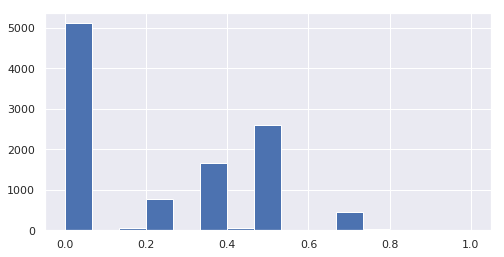

In [6]:
vgp_df = val_df[val_df.ytrue]
plt.figure(figsize=(8, 4))
_ = plt.hist(vgp_df.p_ious, bins=15)
print(np.median(vgp_df.p_ious))

In [7]:
# hard paraphrases
vgp_df = test_df[test_df.ytrue]
# hard_vgps = vgp_df[vgp_df.p_ious<0.25]
hard_vgps = np.logical_and(test_df.ytrue, test_df.p_ious<0.25)
hard_nvgps = np.logical_and(test_df.ytrue==False, test_df.p_ious>=0.25)
hard_exmp = np.logical_or(hard_vgps, hard_nvgps)

# easy paraphrases
easy_vgps = np.logical_and(test_df.ytrue, test_df.p_ious>=0.25)
easy_nvgps = np.logical_and(test_df.ytrue==False, test_df.p_ious<0.25)
easy_exmp = np.logical_or(easy_vgps, easy_nvgps)

print('hard examples: %i (%.1f), p %i n %i' % (sum(hard_exmp), sum(hard_exmp)/ len(test_df), hard_vgps.sum(), hard_nvgps.sum()))
print('easy examples: %i (%.1f), p %i n %i' % (sum(easy_exmp), sum(easy_exmp) / len(test_df), easy_vgps.sum(), easy_nvgps.sum()))

hard examples: 7079 (0.1), p 5367 n 1712
easy examples: 74206 (0.9), p 5433 n 68773


4631804601
a tool | a hat


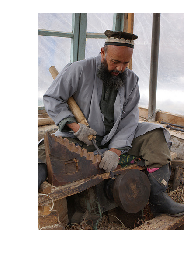

In [8]:
# example of easy VGPs
row = test_df[easy_nvgps].sample()
row = row.iloc[0]
im = plt.imread('data/flickr30k-images/%i.jpg'%row.image)
plt.imshow(im)
plt.axis('off')
print(row.image)
print(row['original_phrase1'], '|', row['original_phrase2'])

4831683216
a green glass bottle | a beer


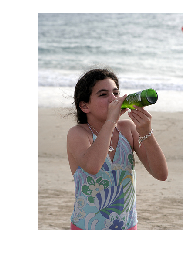

In [215]:
# example of hard VGPs
row = test_df[hard_vgps].sample()
row = row.iloc[0]
im = plt.imread('data/flickr30k-images/%i.jpg'%row.image)
plt.imshow(im)
plt.axis('off')
print(row.image)
print(row['original_phrase1'], '|', row['original_phrase2'])

3601843201
a motorcycle | A motorcycle rider


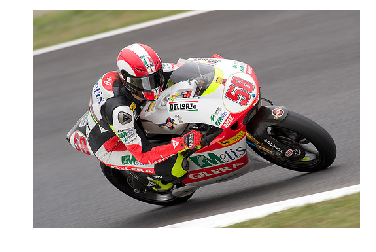

In [8]:
# hard non-VGPs
row = test_df.loc[914]
im = plt.imread('data/flickr30k-images/%i.jpg'%row.image)
plt.imshow(im)
plt.axis('off')
print(row.image)
print(row['original_phrase1'], '|', row['original_phrase2'])

In [11]:
# Ours with plclc
res_files = {
    'Visual-only (PL-CLC)': 'bo_out/vis+plclc/25-20181111-060511/res_test.csv',
    'Visual-only (DDPN)': 'bo_out/vis+ddpn/7-20181107-221739/res_test.csv',
    'Phrase-only': 'bo_out/lng/13-20181102-020120/res_test.csv',
    'Ours (PL-CLC)': 'bo_out/vis+lng+plclc+mult/17-20181108-050238/res_test.csv',
    'Ours (DDPN)': 'bo_out/vis+lng+ddpn+mult/18-20181108-015934/res_test.csv',
}

tbl_df = pd.DataFrame(columns=['method', 'type', 'F1', 'Precision', 'Recall'])

# word overlap baseline
prec, rec, thresh = precision_recall_curve(val_df.ytrue, val_df.p_ious)
f1 = 2 * (prec * rec) / (prec + rec)
best_idx = np.nanargmax(f1)
best_thresh = thresh[best_idx]

f1 = f1_score(test_df.loc[easy_exmp].ytrue, test_df.loc[easy_exmp].p_ious > best_thresh)
prec = precision_score(test_df.loc[easy_exmp].ytrue, test_df.loc[easy_exmp].p_ious > best_thresh)
rec = recall_score(test_df.loc[easy_exmp].ytrue, test_df.loc[easy_exmp].p_ious > best_thresh)
tbl_df = tbl_df.append({'method': 'Word overlap', 'type': 'Easy', 'F1': f1 * 100, 'Precision':prec*100, 'Recall': rec*100}, ignore_index=True)

f1 = f1_score(test_df.loc[hard_exmp].ytrue, test_df.loc[hard_exmp].p_ious > best_thresh)
prec = precision_score(test_df.loc[hard_exmp].ytrue, test_df.loc[hard_exmp].p_ious > best_thresh)
rec = recall_score(test_df.loc[hard_exmp].ytrue, test_df.loc[hard_exmp].p_ious > best_thresh)
tbl_df = tbl_df.append({'method': 'Word overlap', 'type': 'Hard', 'F1': f1 * 100, 'Precision':prec*100, 'Recall': rec*100}, ignore_index=True)

for k, res_f in res_files.items():
    df = pd.read_csv(res_f)

    easy_df = df.loc[easy_exmp]
    f1 = f1_score(easy_df.ytrue, easy_df.ypred)
    prec = precision_score(easy_df.ytrue, easy_df.ypred)
    rec = recall_score(easy_df.ytrue, easy_df.ypred)
    print(k + ' easy vgps: f1 %.2f, prec %.2f, rec %.2f' % (f1 * 100, prec * 100, rec * 100))
    
    tbl_df = tbl_df.append({'method': k, 'type': 'Easy', 'F1': f1 * 100, 'Precision':prec*100, 'Recall': rec*100}, ignore_index=True)
    
    hard_df = df.loc[hard_exmp]
    f1 = f1_score(hard_df.ytrue, hard_df.ypred)
    prec = precision_score(hard_df.ytrue, hard_df.ypred)
    rec = recall_score(hard_df.ytrue, hard_df.ypred)
    print(k + ' hard vgps: f1 %.2f, prec %.2f, rec %.2f' % (f1 * 100, prec * 100, rec * 100))
    
    tbl_df = tbl_df.append({'method': k, 'type': 'Hard', 'F1': f1 * 100, 'Precision':prec*100, 'Recall': rec*100}, ignore_index=True)
    


Visual-only (PL-CLC) easy vgps: f1 52.31, prec 40.75, rec 73.05
Visual-only (PL-CLC) hard vgps: f1 66.67, prec 80.24, rec 57.03
Visual-only (DDPN) easy vgps: f1 59.41, prec 48.31, rec 77.14
Visual-only (DDPN) hard vgps: f1 76.56, prec 86.69, rec 68.55
Phrase-only easy vgps: f1 89.61, prec 84.28, rec 95.66
Phrase-only hard vgps: f1 81.18, prec 85.27, rec 77.45
Ours (PL-CLC) easy vgps: f1 88.31, prec 82.17, rec 95.44
Ours (PL-CLC) hard vgps: f1 81.44, prec 84.87, rec 78.27
Ours (DDPN) easy vgps: f1 89.47, prec 84.97, rec 94.48
Ours (DDPN) hard vgps: f1 83.14, prec 86.83, rec 79.75


In [12]:
tbl_df

,method,type,F1,Precision,Recall
0,Word overlap,Easy,97.733405,95.567282,100.000000
1,Word overlap,Hard,5.548688,10.553814,3.763741
2,Visual-only (PL-CLC),Easy,52.313167,40.745303,73.053562
3,Visual-only (PL-CLC),Hard,66.673927,80.235911,57.033725
4,Visual-only (DDPN),Easy,59.413099,48.311239,77.139702
5,Visual-only (DDPN),Hard,76.558110,86.687088,68.548537
6,Phrase-only,Easy,89.611173,84.284788,95.656175
7,Phrase-only,Hard,81.175552,85.271795,77.454816
8,Ours (PL-CLC),Easy,88.307928,82.171157,95.435303
9,Ours (PL-CLC),Hard,81.438403,84.868687,78.274641


In [34]:
83.640768 - 76.746786

6.893981999999994

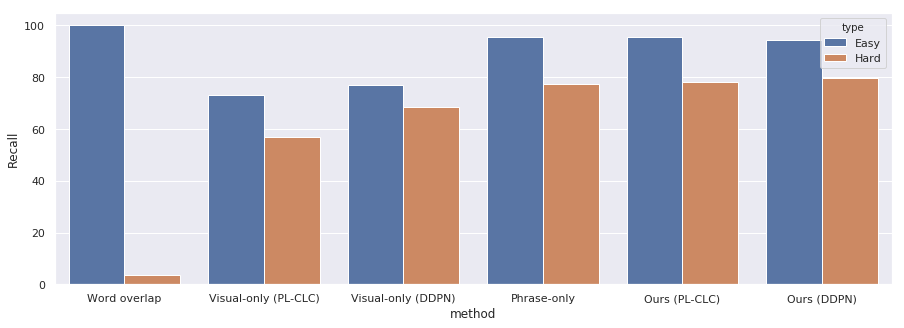

In [13]:
plt.figure(figsize=(15, 5))
sns.barplot(x='method', y='Recall', hue='type', data=tbl_df)

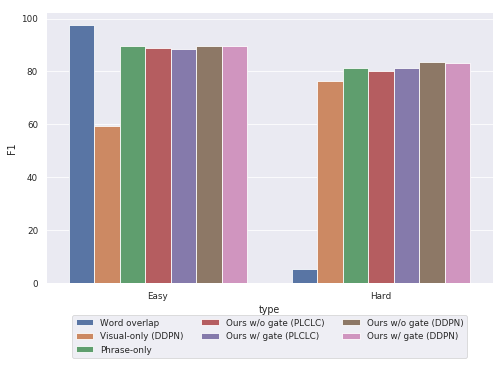

In [36]:
plt.figure(figsize=(8, 5))
sns.barplot(x='type', y='F1', hue='method', data=tbl_df)
plt.gca().legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3)
plt.savefig('figures/cvpr/hard-easy-f1.pdf', bbox_inches='tight')

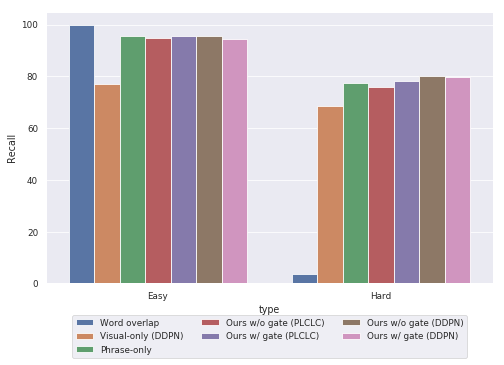

In [37]:
plt.figure(figsize=(8, 5))
sns.barplot(x='type', y='Recall', hue='method', data=tbl_df)
plt.gca().legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3)
plt.savefig('figures/cvpr/hard-easy-recall.pdf', bbox_inches='tight')

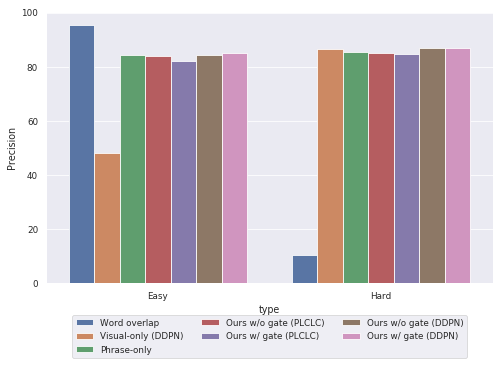

In [38]:
plt.figure(figsize=(8, 5))
sns.barplot(x='type', y='Precision', hue='method', data=tbl_df)
plt.gca().legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3)
plt.savefig('figures/cvpr/hard-easy-precision.pdf', bbox_inches='tight')

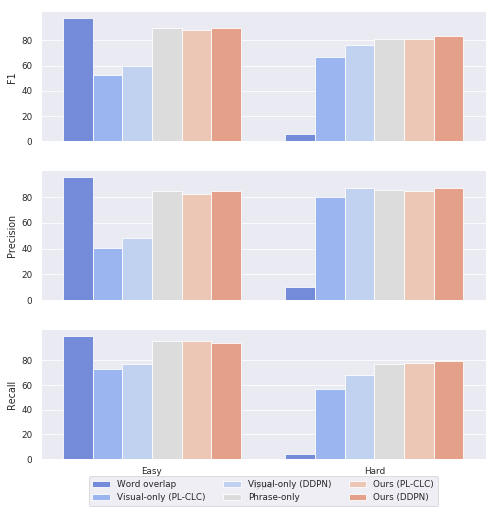

In [17]:
sns.set_context("paper")
f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(7, 7), sharex=True)

# palette = {
#     'Word overlap':,
#     'phrase-only'
#     'Visual-only (synthesized)':
#     'Visual-only (synthesized)':
# }
palette=sns.color_palette("coolwarm", 7)
sns.barplot(x='type', y='F1', hue='method', data=tbl_df, ax=ax1, palette=palette)
sns.barplot(x='type', y='Precision', hue='method', data=tbl_df, ax=ax2, palette=palette)
sns.barplot(x='type', y='Recall', hue='method', data=tbl_df, ax=ax3, palette=palette)
plt.gca().legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3)

ax1.legend().set_visible(False)
ax1.get_xaxis().set_visible(False)
ax2.legend().set_visible(False)
ax2.get_xaxis().set_visible(False)

sns.despine(bottom=True)
plt.setp(f.axes, yticks=np.arange(0, 100, 20))
plt.tight_layout(h_pad=2)
plt.savefig('figures/cvpr/hard-easy.pdf', bbox_inches='tight')